In [1]:
# Import libraries
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn.functional as F

# A module to print a model summary (outputs shape, number of parameters, ...)
import torchsummary

# Tensorboard for visualization
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm

import pandas as pd
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
from sklearn.model_selection import train_test_split


# Custom modules and packages
import utils
import params.supervised_learning
import utils_supervised
import traversalcost.utils
from dataset import SupervisedLearningDataset
from model import SupervisedNetwork 
from train import train
from validate import validate
from test import test
from result import parameters_table, generate_log
from utils import compute_mean_std, Standardize

## Load learning parameters

In [2]:
LEARNING_PARAMS = params.supervised_learning.LEARNING

## Prepare data

In [3]:
# Standardize the data
mean, std = compute_mean_std(params.supervised_learning.DATASET)

# Generate a dummy signal
signal = np.random.rand(len(mean))

# Instantiate the standardize class
standardize = Standardize(mean, std)

# Standardize the signal
signal = standardize.standardize(signal)

# De-standardize the signal
signal = standardize.destandardize(signal)

In [4]:
# Create a Dataset for training
train_set = SupervisedLearningDataset(
    traversal_costs_file=params.supervised_learning.DATASET+"traversal_costs_train.csv",
    features_directory=params.supervised_learning.DATASET+"features",
    transform = standardize.standardize
)

# Create a Dataset for validation
# (same as training here since no transformation is applied to the data,
# train and validation sets will be split later)
val_set = SupervisedLearningDataset(
    traversal_costs_file=params.supervised_learning.DATASET+"traversal_costs_train.csv",
    features_directory=params.supervised_learning.DATASET+"features",
    transform = standardize.standardize
)

# Create a Dataset for testing
test_set = SupervisedLearningDataset(
    traversal_costs_file=params.supervised_learning.DATASET+"traversal_costs_test.csv",
    features_directory=params.supervised_learning.DATASET+"features",
    transform = standardize.standardize
)

In [5]:
# Set the train dataset size
train_size = params.supervised_learning.TRAIN_SIZE/\
    (1-params.supervised_learning.TEST_SIZE)

# Splits train data indices into train and validation data indices
train_indices, val_indices = train_test_split(range(len(train_set)),
                                              train_size=train_size)

# Extract the corresponding subsets of the train dataset
train_set = Subset(train_set, train_indices)
val_set = Subset(val_set, val_indices)


# Combine a dataset and a sampler, and provide an iterable over the dataset
# (setting shuffle argument to True calls a RandomSampler, and avoids to
# have to create a Sampler object)
train_loader = DataLoader(
    train_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=True,
    num_workers=12,  # Asynchronous data loading and augmentation
    pin_memory=True,  # Increase the transferring speed of the data to the GPU
)

val_loader = DataLoader(
    val_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=True,
    num_workers=12,
    pin_memory=True,
)

test_loader = DataLoader(
    test_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=False,  # SequentialSampler
    num_workers=12,
    pin_memory=True,
)

In [6]:
# Create a Dataset for training
# train_set = SupervisedLearningDataset(
#     params.supervised_learning.DATASET + "traversalcosts_train.csv",
#     params.supervised_learning.DATASET + "/features")

# # Create a Dataset for testing
# test_set = SupervisedLearningDataset(
#     params.supervised_learning.DATASET +"traversalcosts_test.csv",
#     params.supervised_learning.DATASET + "features")

In [7]:
# # Combine a dataset and a sampler, and provide an iterable over the dataset
# # (setting shuffle argument to True calls a RandomSampler, and avoids to
# # have to create a Sampler object)

# train_loader = DataLoader(
#     train_set,
#     batch_size= params.supervised_learning.BATCH_SIZE,
#     shuffle=True,
#     num_workers=12,  # Asynchronous data loading and augmentation
#     pin_memory=True,  # Increase the transferring speed of the data to the GPU
# )

# test_loader = DataLoader(
#     test_set,
#     batch_size= params.supervised_learning.BATCH_SIZE,
#     shuffle=True,
#     num_workers=12,  # Asynchronous data loading and augmentation
#     pin_memory=True,  # Increase the transferring speed of the data to the GPU
# )

In [8]:
# Get the number of samples per split
NB_TRAIN = len(train_set)
NB_VAL = len(val_set)
NB_TEST = len(test_set)

In [9]:
# Display the splits ratio
NB_SAMPLES = NB_TRAIN + NB_VAL + NB_TEST

print(f"{np.round(NB_TRAIN/NB_SAMPLES*100)} % of the data for training ({NB_TRAIN} samples)")
print(f"{np.round(NB_VAL/NB_SAMPLES*100)} % of the data for validation ({NB_VAL} samples)")
print(f"{np.round(NB_TEST/NB_SAMPLES*100)} % of the data for testing ({NB_TEST} samples)")

70.0 % of the data for training (672 samples)
15.0 % of the data for validation (144 samples)
15.0 % of the data for testing (144 samples)


## GPU ?

In [10]:
# Use a GPU if available
# device = "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}\n")

Device: cuda



## Training and validation

In [11]:
# Create a model
nb_input_features = len(train_set[0][0])
model = SupervisedNetwork(input_size=nb_input_features).to(device=device)

In [12]:
# Set the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.SGD(model.parameters(),
                      lr=LEARNING_PARAMS["learning_rate"],
                      momentum=LEARNING_PARAMS["momentum"],
                      weight_decay=LEARNING_PARAMS["weight_decay"])

# Create tensors to store the loss values
loss_values = torch.zeros(2, LEARNING_PARAMS["nb_epochs"])

# Loop over the epochs
for epoch in range(LEARNING_PARAMS["nb_epochs"]):
    
    # Training
    train_loss = train(model,
                       device,
                       train_loader,
                       optimizer,
                       criterion,
                       epoch)
    
    # Validation
    val_loss = validate(model,
                        device,
                        val_loader,
                        criterion,
                        epoch) 
    
    print("Train loss: ", train_loss)
    print("Validation loss: ", val_loss)
    
    # Store the computed losses
    loss_values[0, epoch] = train_loss
    loss_values[1, epoch] = val_loss

  0%|          | 0/68 [00:00<?, ?batch/s]

Epoch 0 [val]: 100%|██████████| 15/15 [00:01<00:00, 13.91batch/s, batch_loss=4.52]


Train loss:  31.438053369522095
Validation loss:  23.127452723185222


Epoch 1 [val]: 100%|██████████| 15/15 [00:01<00:00, 14.06batch/s, batch_loss=7.66]


Train loss:  8.54120491883334
Validation loss:  7.864767710367839


Epoch 2 [val]: 100%|██████████| 15/15 [00:01<00:00, 14.85batch/s, batch_loss=4.97]


Train loss:  8.300603607121635
Validation loss:  6.717735958099365


Epoch 3 [val]: 100%|██████████| 15/15 [00:01<00:00, 13.90batch/s, batch_loss=4.36]


Train loss:  6.81260341055253
Validation loss:  7.052367989222208


Epoch 4 [val]: 100%|██████████| 15/15 [00:01<00:00, 14.34batch/s, batch_loss=2.77]

Train loss:  7.391490259591271
Validation loss:  7.378290224075317


## Visualization 

Text(0.5, 0, 'Epoch')

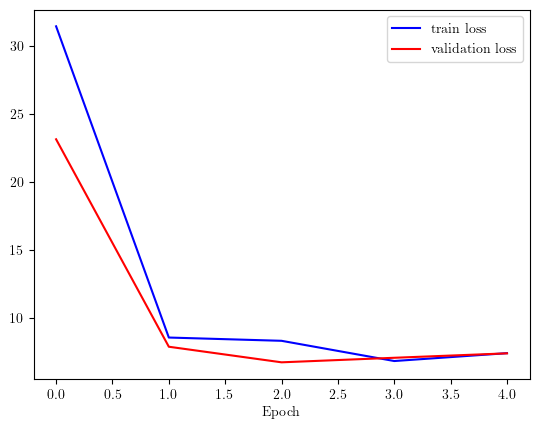

In [13]:
# Loss
train_losses = loss_values[0]
val_losses = loss_values[1]

figure = plt.figure()

plt.plot(train_losses, "b", label="train loss")
plt.plot(val_losses, "r", label="validation loss")

plt.legend()
plt.xlabel("Epoch")

## Testing

In [14]:
# Test the model
test_loss = test(model,
                 device,
                 test_loader,
                 criterion)

print("Test loss: ", test_loss)

Test loss:  6.97802799542745


## Compute and display traversal costs

In [15]:
# Compute the traversal costs from the features of the dataset
costs_df = traversalcost.utils.compute_traversal_costs(
    dataset=params.supervised_learning.DATASET,
    cost_function=model.to(device="cpu"),
    to_tensor=True,
    standardize=standardize.standardize,
)

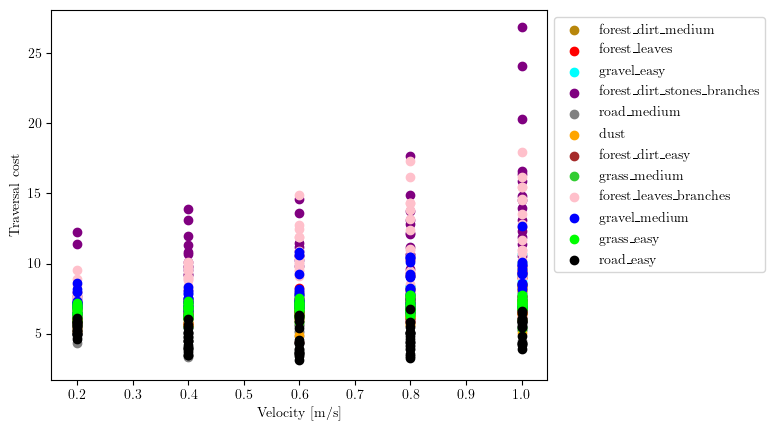

In [16]:
# Display the traversal costs
cost_graph = traversalcost.utils.display_traversal_costs(costs_df)

In [17]:
# costs_df_true = pd.read_csv(params.supervised_learning.DATASET+"traversal_costs.csv")

In [18]:
# traversalcost.utils.display_traversal_costs(costs_df_true)

## Generate a log directory

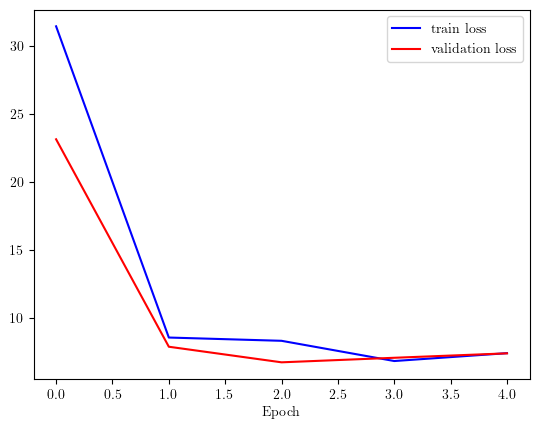

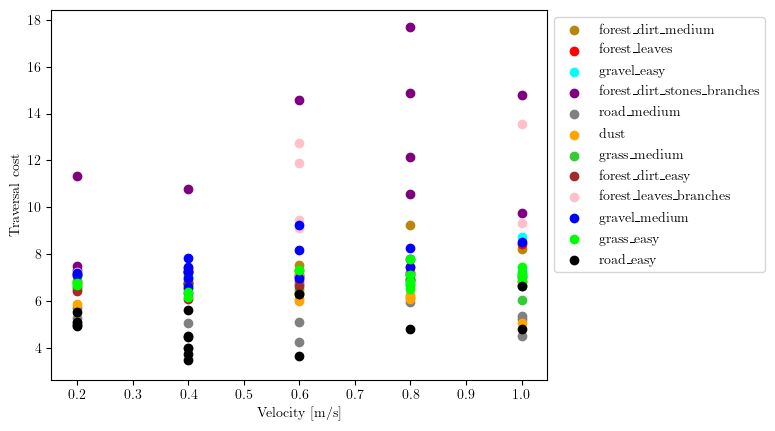

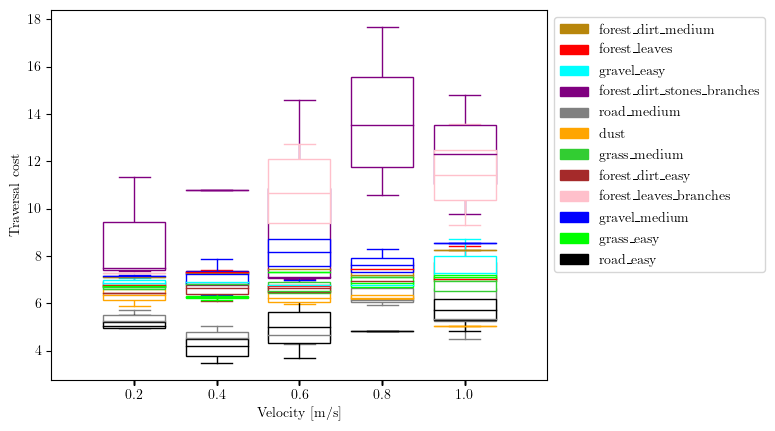

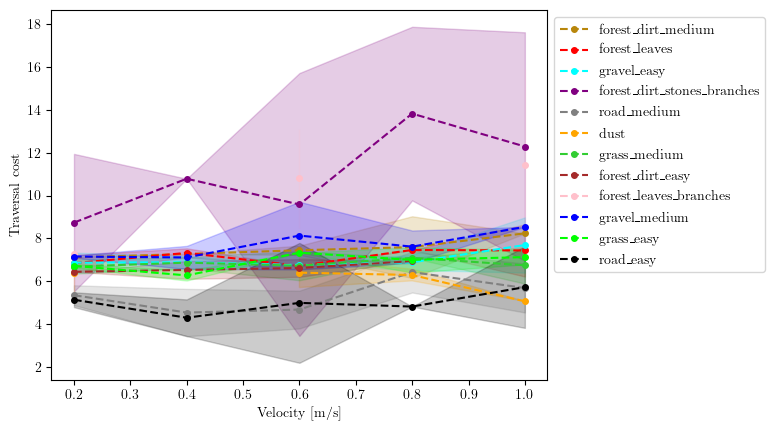

In [19]:
# Get the learning parameters table
params_table = parameters_table(dataset=params.supervised_learning.DATASET,
                                learning_params=LEARNING_PARAMS)

# Set the path to the results directory
if params.supervised_learning.LOG_DIR:
    results_directory = "logs/_" +\
                        params.supervised_learning.LOG_DIR
else:
    results_directory = "logs/_" +\
                        datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
                        
# Generate the log directory
generate_log(dataset_directory=params.supervised_learning.DATASET,
             results_directory=results_directory,
             test_loss=test_loss,
             parameters_table=params_table,
             model=model,
             loss_values=loss_values,
             standardize=standardize.standardize,
             labels_file="traversal_costs_test.csv")